## **Obesity Multi-Class Classification - Prediction of Obesity Risk**

https://www.kaggle.com/competitions/playground-series-s4e2/overview

"The goal of this competition is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease."

#### Steps:
1. Import data via Pandas
2. Review and understand the data with summary statistics and review of data types
3. Check for missing values and fill as needed, and one-hot encode binary categorical values
4. Check for congruency between train and test sets for category values
5. Review correlation between features to determine viablity of clustering
6. Split training data into training and validation set
7. Complete one-hot encoding on categorical values (non-binary ones)
8. Scale data-- fit to and transform training data, and transform all feature data accordingly 
9. Identify potential features to pair with PCA, and performance PCA where correlation is sufficiently high
10. Create model evaluation tool with Gridsearch to hypertune parameters while selecting best model to persist<br> > "Best" model is scored on accuracy on the validation set
11. Refit the best model on the full data and use it to predict the target values for the test set (and submit these predictions)

### 1. Import data via Pandas

In [1]:
# Import the libraries I'll be using for data analysis and visualization
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
# Read in data from provided files -- personal Jupyter Notebook version
trainval = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sub_example = pd.read_csv("data/sample_submission.csv")

In [3]:
# # Read in data from provided files -- Kaggle Notebook version
# trainval = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
# test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
# sub_example = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")

Let's take a quick look at the data, both the training (what I'm using for training and validation) set and test set:

In [4]:
trainval.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


### 2. Review and understand the data with summary statistics and review of data types
The ID won't be helpful in building our prediction models, but we will need it for the submission, so we'll save it from the test set and drop it from the feature sets for now.  We'll also shorten the `family_history_with_overweight` feature to just `famhist`.

In [6]:
trainval.drop(columns='id', inplace=True)
trainval.rename(columns={'family_history_with_overweight':'famhist'}, inplace=True)
test_ids = test['id']
test.drop(columns='id', inplace=True)
test.rename(columns={'family_history_with_overweight':'famhist'}, inplace=True)

Now let's look at the values and their data types

In [7]:
trainval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      20758 non-null  object 
 1   Age         20758 non-null  float64
 2   Height      20758 non-null  float64
 3   Weight      20758 non-null  float64
 4   famhist     20758 non-null  object 
 5   FAVC        20758 non-null  object 
 6   FCVC        20758 non-null  float64
 7   NCP         20758 non-null  float64
 8   CAEC        20758 non-null  object 
 9   SMOKE       20758 non-null  object 
 10  CH2O        20758 non-null  float64
 11  SCC         20758 non-null  object 
 12  FAF         20758 non-null  float64
 13  TUE         20758 non-null  float64
 14  CALC        20758 non-null  object 
 15  MTRANS      20758 non-null  object 
 16  NObeyesdad  20758 non-null  object 
dtypes: float64(8), object(9)
memory usage: 2.7+ MB


### 3. Check for missing values and fill as needed, and one-hot encode binary categorical values

It doesnt' appear any values are misisng, but let's confirm that real quick

In [8]:
print('Number of missing values in training/validation set:',trainval.isnull().sum().sum())
print('Number of missing values in test set:',test.isnull().sum().sum())

Number of missing values in training/validation set: 0
Number of missing values in test set: 0


Values that are just 'yes' or 'no' can be reassigned as binary 0 or 1, so they are numeric.  We can list out the types of values that are in each object/category datatype from the featureset:

In [9]:
# Cycle through columns from the test set whose dtypes are not numbers...
for obj_col in test.select_dtypes(exclude=['int64','float64']).columns:
    # ...print value counts for each column for the test and training sets 
    print('Training/Validation:',trainval[obj_col].value_counts())
    print('Test:',test[obj_col].value_counts(),'\n','--------------------------')

Training/Validation: Female    10422
Male      10336
Name: Gender, dtype: int64
Test: Female    6965
Male      6875
Name: Gender, dtype: int64 
 --------------------------
Training/Validation: yes    17014
no      3744
Name: famhist, dtype: int64
Test: yes    11384
no      2456
Name: famhist, dtype: int64 
 --------------------------
Training/Validation: yes    18982
no      1776
Name: FAVC, dtype: int64
Test: yes    12583
no      1257
Name: FAVC, dtype: int64 
 --------------------------
Training/Validation: Sometimes     17529
Frequently     2472
Always          478
no              279
Name: CAEC, dtype: int64
Test: Sometimes     11689
Frequently     1617
Always          359
no              175
Name: CAEC, dtype: int64 
 --------------------------
Training/Validation: no     20513
yes      245
Name: SMOKE, dtype: int64
Test: no     13660
yes      180
Name: SMOKE, dtype: int64 
 --------------------------
Training/Validation: no     20071
yes      687
Name: SCC, dtype: int64
Test: no 

I can see that `famhist`, `FAVC`, `SCC`, and `SMOKE` are all yes or no, we we can map those values to 1 or 0 respectively and update their columns:

In [10]:
trainval['famhist'] = trainval['famhist'].map(lambda x:1 if x=='yes' else 0)
trainval['FAVC'] = trainval['FAVC'].map(lambda x:1 if x=='yes' else 0)
trainval['SMOKE'] = trainval['SMOKE'].map(lambda x:1 if x=='yes' else 0)
trainval['SCC'] = trainval['SCC'].map(lambda x:1 if x=='yes' else 0)
test['famhist'] = test['famhist'].map(lambda x:1 if x=='yes' else 0)
test['FAVC'] = test['FAVC'].map(lambda x:1 if x=='yes' else 0)
test['SMOKE'] = test['SMOKE'].map(lambda x:1 if x=='yes' else 0)
test['SCC'] = test['SCC'].map(lambda x:1 if x=='yes' else 0)

### 4. Check for congruency between train and test sets for category values

I want to confirm as well that the values in each categorical feature are also in the test set.  This will be needed, since we'll be applying one-hot encoding later on and we need a consistent list of features. 

In [11]:
# Cycle through columns from the test set whose dtypes are not numbers...
for obj_col in test.select_dtypes(exclude=['int64','float64']).columns:
    # ...create a list of the labels from those columns, both training and test sets...
    trainval_obj_col_options = sorted(list(trainval[obj_col].value_counts().index))
    test_obj_col_options = sorted(list(test[obj_col].value_counts().index))
    # ...if the values are not shared, then make note of this
    if test_obj_col_options == trainval_obj_col_options:
        print(f'These options in the training and test set match for column {obj_col}\n')
    else:
        print(f'In column {obj_col} of testing/validation set, there options are {trainval_obj_col_options}')
        print(f'In the test set, there options are {test_obj_col_options}')
        print('These options do NOT match\n')

These options in the training and test set match for column Gender

These options in the training and test set match for column CAEC

In column CALC of testing/validation set, there options are ['Frequently', 'Sometimes', 'no']
In the test set, there options are ['Always', 'Frequently', 'Sometimes', 'no']
These options do NOT match

These options in the training and test set match for column MTRANS



We cna see the `CALC` in the test set has an option of `Always` which does not show up in the training/validation set.  We will need to add this in at the appropriate time.  For now, let's take a fresh look at our updated training/validation feature set.

In [12]:
trainval.head()

,Gender,Age,Height,Weight,famhist,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Although not likely criticla, I like to assing a datatype of `category` where appropriate, and this is true for the remaining `object` features.

In [13]:
trainval['Gender'] = trainval['Gender'].astype('category')
trainval['CAEC'] = trainval['CAEC'].astype('category')
trainval['CALC'] = trainval['CALC'].astype('category')
trainval['MTRANS'] = trainval['MTRANS'].astype('category')
test['Gender'] = test['Gender'].astype('category')
test['CAEC'] = test['CAEC'].astype('category')
test['CALC'] = test['CALC'].astype('category')
test['MTRANS'] = test['MTRANS'].astype('category')

If we now show the info on the training set, we cna see that only our binary 1/0 (yes/no), float/integer, and categorical values remain, save for the actual target value, `NObeyesdad` which we can leave as an object since we'll be separating it from the training set shortly

In [14]:
trainval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Gender      20758 non-null  category
 1   Age         20758 non-null  float64 
 2   Height      20758 non-null  float64 
 3   Weight      20758 non-null  float64 
 4   famhist     20758 non-null  int64   
 5   FAVC        20758 non-null  int64   
 6   FCVC        20758 non-null  float64 
 7   NCP         20758 non-null  float64 
 8   CAEC        20758 non-null  category
 9   SMOKE       20758 non-null  int64   
 10  CH2O        20758 non-null  float64 
 11  SCC         20758 non-null  int64   
 12  FAF         20758 non-null  float64 
 13  TUE         20758 non-null  float64 
 14  CALC        20758 non-null  category
 15  MTRANS      20758 non-null  category
 16  NObeyesdad  20758 non-null  object  
dtypes: category(4), float64(8), int64(4), object(1)
memory usage: 2.1+ MB


### 5. Review correlation between features to determine viablity of clustering

I'd like to see if we might be able to engineer a feature or two based on clustering.  Clustering algorithms typically utilize unsupervised ML algorithms to segment a data set within its feature space.  I'm going to attempt to create a few pairplots between features and the target, and this will be aided by identifying columns based on their data types, and also mapping the target values to numeric values, which I'll do in the next four lines and culminating in a new colun in the training dataset that assings an integer to each obesity class:

In [15]:
float_cols = list(trainval.select_dtypes(include='float64').columns)
cat_cols = list(trainval.select_dtypes(include='category').columns)
bin_cols =  list(trainval.select_dtypes(include='int64').columns)
class_cols = cat_cols + bin_cols

In [16]:
target_values = list(trainval['NObeyesdad'].unique())
target_values

['Overweight_Level_II',
 'Normal_Weight',
 'Insufficient_Weight',
 'Obesity_Type_III',
 'Obesity_Type_II',
 'Overweight_Level_I',
 'Obesity_Type_I']

In [17]:
target_d = {'Overweight_Level_II':2,
            'Normal_Weight':0,
            'Insufficient_Weight':-1,
            'Obesity_Type_III':5,
            'Obesity_Type_II':4,
            'Overweight_Level_I':1,
            'Obesity_Type_I':3}

In [18]:
trainval['NObeyesdadCode'] = trainval['NObeyesdad'].map(lambda x:target_d[x])

Ideally, to review potential for clustering, I would be able to view all combination of features and see if any specific categorical features were easily separable from its counterparts. That is, I am asking the questions-- when plotting features and the target against one another, is there a categorical feature around which is can be illuminating to draw dividing lines around.  If we can do this, then it migh help us create a new class feature that will our later models can better utilize when making predicitons.

My first attempt here took all the continuous numerical values and plotted them with our target, labeling by each categorical or binary feature.  I didn't print it all in order to save space.  Suffice it to say that there were no obvious and distinct clusters.  In all cases, there was significant overlap of the kernel density plots, which meant we had the instances of each label overlapping across the feature and target space.   

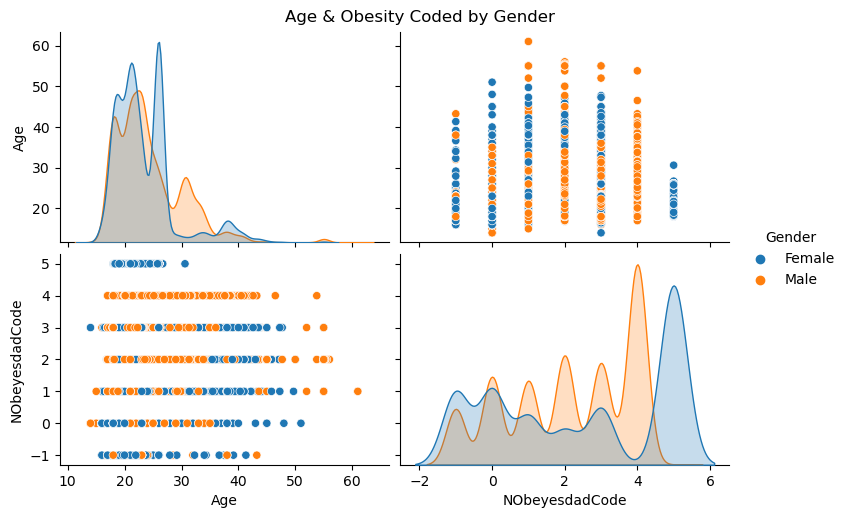

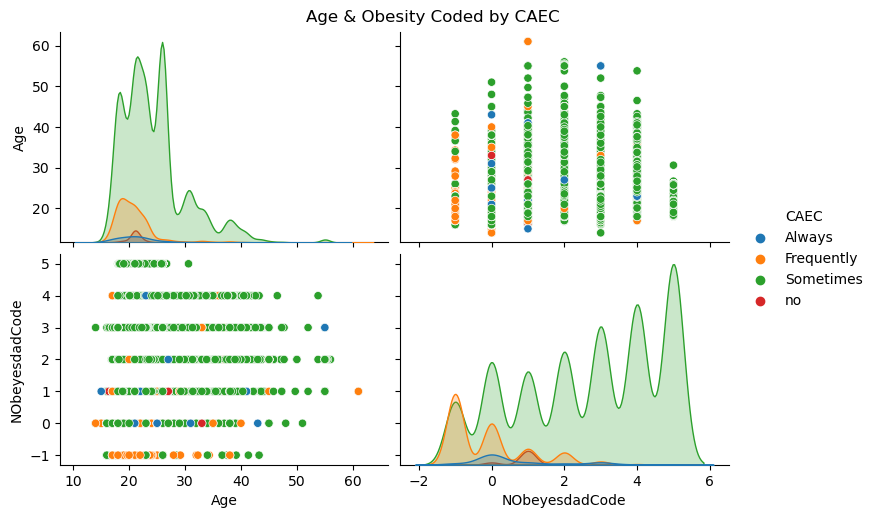

In [19]:
# For each continuous numerical feature...
for float_col in float_cols[:1]:
    # ...and for each feature that is binary or categorical...
    for class_col in class_cols[:2]:
        # ...pull out the data from the dataframe associated with those columns...
        cols = [float_col] + [class_col] + ['NObeyesdadCode']
        # ... and create a pair plot
        fig = sns.pairplot(trainval[cols], hue=class_col, aspect=1.5)
        fig.fig.suptitle(f'{float_col} & Obesity Coded by {class_col}', y=1.02)
        plt.show()

Next, I looked at plotting each continous numerical feature against the other ones, and then mapping the target categories on these.  If there were obvouis groups, then we would see this in the data. And in some of the graphs we do-- there are clear striations in the target label when plotting `Weight` vs `Height`.  See below-- again, I've only printed some of these combinations to save space.

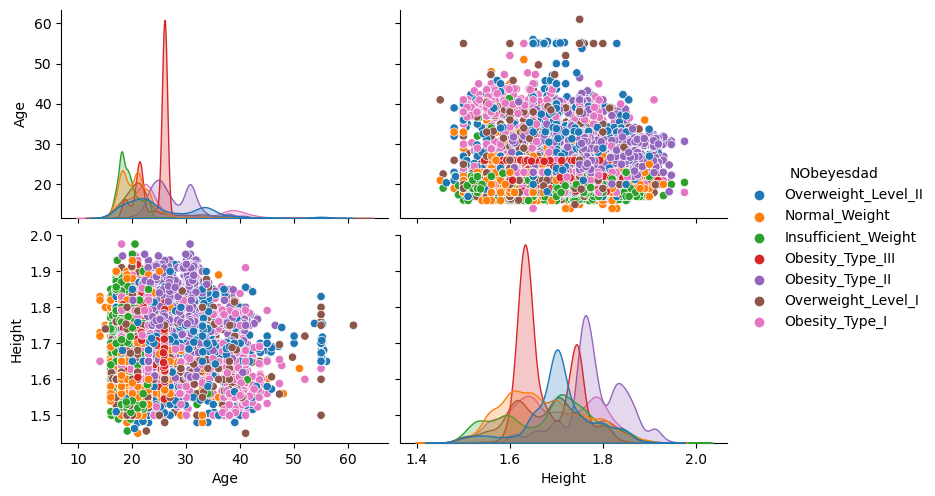

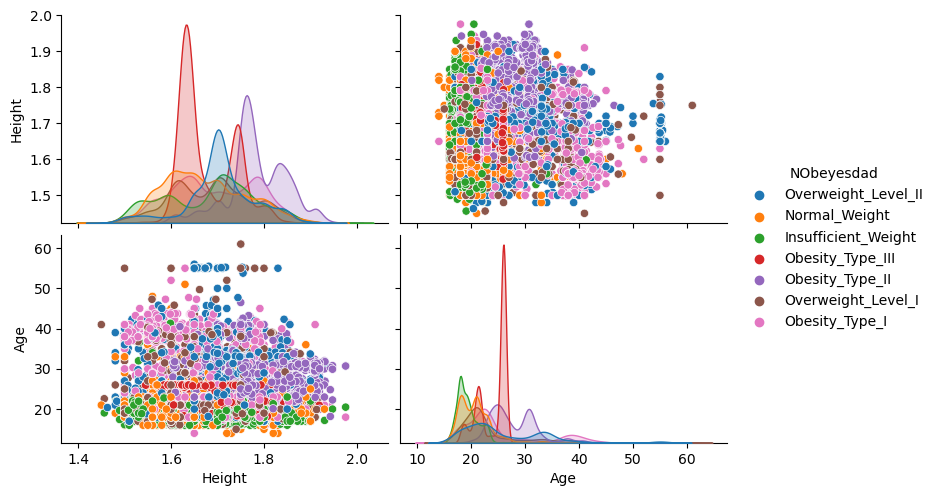

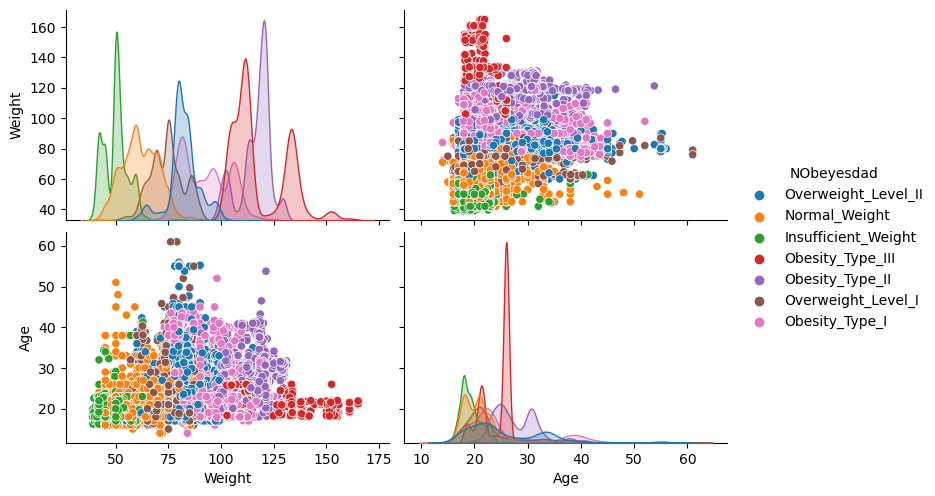

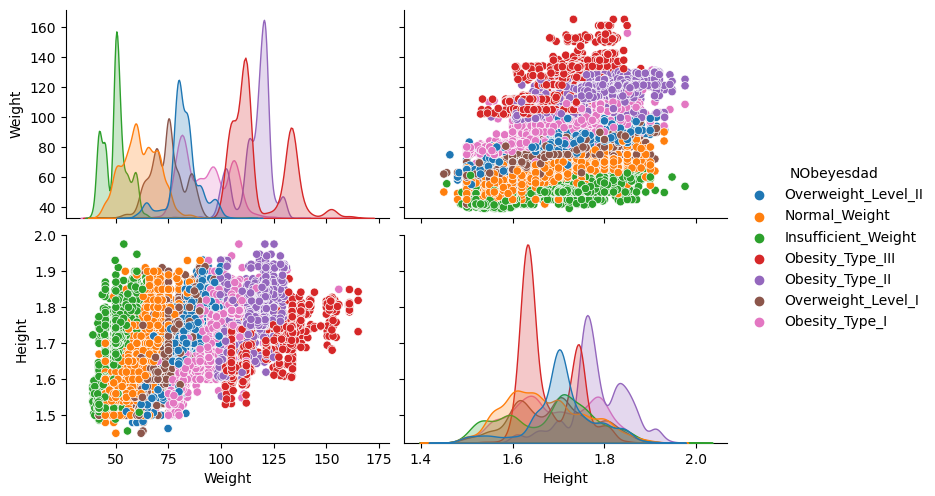

In [20]:
# For each continuous numerical feature...
for float_col1 in float_cols[:3]:
    # ...and a second continuous numerical feature...
    for float_col2 in float_cols[:2]:
        # If these aren't the same value
        if (float_col1 != float_col2) and (float_col1 != 'NObeyesdad') and (float_col2 != 'NObeyesdad'):
            # ...pull out the data from the dataframe associated with those columns...
            cols = [float_col1] + [float_col2] + ['NObeyesdad']
            # ... and create a pair plot
            sns.pairplot(trainval[cols], hue='NObeyesdad', aspect=1.5)
            fig.fig.suptitle(f'{float_col1} & {float_col2}', y=1.02)
            plt.show()

...But, this was about the only instance where this was the case, and it is in fact built into the definiton of the target label.  Thus, I don't believe that this sort of clustering would necessarily provide any additional information to the model.  At this point, I'm going to get rid of that new column with the numerical representation of the target label:

In [21]:
trainval.drop(columns=['NObeyesdadCode'], inplace=True)

In [22]:
trainval.head()

,Gender,Age,Height,Weight,famhist,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


### 6. Split training data into training and validation set

Now we can focus on training a number of classiifer supervised machine learning models on our data.  Before we do so, we'll need to process the data a bit; we'll want to separate out our validation and training sets from the original training set, apply scaler transformations, and then consider PCA.  First to create our test splits:

In [23]:
from sklearn.model_selection import train_test_split
y_trainval = trainval['NObeyesdad']
X_trainval = trainval.iloc[:,0:16]
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=126)

### 7. Complete one-hot encoding on categorical values (non-binary ones)

Next we need to adjust the remaining categorical variables with one-hot encoding, and we can use Pandas get_dummies() method for this.  We also need to add into the training sets the one CALC option that shows up in the test set but not elsewhere:

In [24]:
# One-Hot Encoding of categorical values
X_train = pd.get_dummies(X_train, prefix=None, prefix_sep='_')
X_val = pd.get_dummies(X_val, prefix=None, prefix_sep='_')
X_trainval = pd.get_dummies(X_trainval, prefix=None, prefix_sep='_')
test = pd.get_dummies(test, prefix=None, prefix_sep='_')

# We don't have the same number of types of input for the CALC column between training/val and test, so I'm adding that here
X_train['CALC_Always'] = 0
X_val['CALC_Always'] = 0
X_trainval['CALC_Always'] = 0
cols = list(X_train.columns)
idx = cols.index('CALC_Frequently')
cols.insert(idx,'CALC_Always')
cols.pop()
X_train = X_train.loc[:,cols]
X_val = X_val.loc[:,cols]
X_trainval = X_trainval.loc[:,cols]

### 8. Scale data-- fit to and transform training data, and transform all feature data accordingly 

Scaling is done on the training feature set, and then used to transform the other data to avoid data leakage.  Given the type of information found in the numerical, continuous data-- that is, given that the values don't have meaning in relation to one another, like age in years vs. height in inches-- scaling makes sense.  And a standard, normalizing scaler works well on this data.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_trainval_s = scaler.transform(X_trainval)
test_s = scaler.transform(test)

### 9. Identify potential features to pair with PCA, and performance PCA where correlation is sufficiently high

When considering if Principcal Component Analysis makes sense, we typically want to take a look at features that are correlated fairly highly with one another.  A good way to look at this is through a heat map, and we can pull out the correlation coefficients with Pandas too:

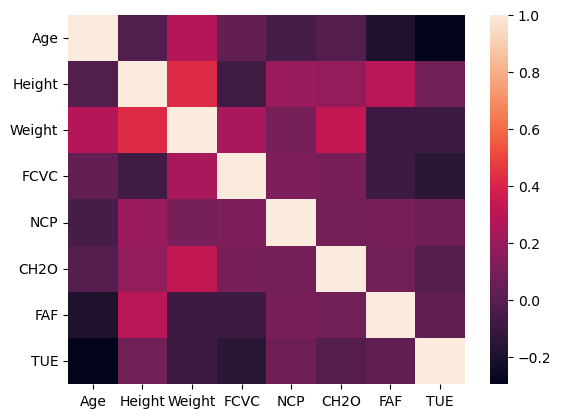

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.020349,0.279488,0.036954,-0.055933,-0.012937,-0.193717,-0.295689
Height,-0.020349,1.000000,0.412955,-0.074459,0.204485,0.182977,0.291956,0.081843
Weight,0.279488,0.412955,1.000000,0.241585,0.095770,0.322504,-0.089069,-0.083779
FCVC,0.036954,-0.074459,0.241585,1.000000,0.114611,0.103424,-0.088722,-0.153519
NCP,-0.055933,0.204485,0.095770,0.114611,1.000000,0.091416,0.103783,0.066653
CH2O,-0.012937,0.182977,0.322504,0.103424,0.091416,1.000000,0.079378,-0.005653
FAF,-0.193717,0.291956,-0.089069,-0.088722,0.103783,0.079378,1.000000,0.024470
TUE,-0.295689,0.081843,-0.083779,-0.153519,0.066653,-0.005653,0.024470,1.000000


In [26]:
sns.heatmap(X_train.loc[:,float_cols].corr(), annot=False)
plt.show()
corr = X_train.loc[:,float_cols].corr()
corr

I think any absolute coefficient above about 0.3 is a worthy candidate for a pair of features upon which PCA will be helpful.  The lines below find those individual values and then pull out their locations (features indices in the correlation matrix).  We cna then pull out those pairs and their actual column names): 

In [27]:
feats = list(corr.columns)
locs = np.where(abs(corr) >= 0.3)
locs = list(zip(locs[0],locs[1]))
pca_cols_idx = [(x[0],x[1]) for x in locs if ((x[0] < x[1]) and (feats[x[0]][:4] != feats[x[1]][:4]))]
pca_cols = [(feats[x[0]],feats[x[1]]) for x in locs if ((x[0] < x[1]) and (feats[x[0]][:4] != feats[x[1]][:4]))]
print('Feature Indices in Corr Matrix with Sufficient Correlation:',pca_cols_idx)
print('Feature in Corr Matrix with Sufficient Correlation:',pca_cols)

Feature Indices in Corr Matrix with Sufficient Correlation: [(1, 2), (2, 5)]
Feature in Corr Matrix with Sufficient Correlation: [('Height', 'Weight'), ('Weight', 'CH2O')]


The fact that `Height` and `Weight` show up together with high correlation is not suprising.  We saw this in our initial look at clustering and it also is intuitive, as the taller you are, the more you tend to weigh.  The other pair-- `Weight` and `CH20`-- is less obvious.

Performing PCA just on these pairs means that we'll need to loop through the pairs, perform PCA with the PCA class from sklearn, and then append this information to the dataframes.  We'll do this on all of the feature sets, and as before with scaling, we'll only fit to our training data.

In [28]:
from sklearn.decomposition import PCA

In [29]:
# Initialize empty lists for the actual PCA class instances and the PCA values for each set of data
pcas = []
X_train_s_pcas = []
X_val_s_pcas = []
test_s_pcas = []
X_trainval_s_pcas = []
# For each pair in the index of paired features...
for pca_cols in pca_cols_idx:
    # ...Initilize a PCA instance...
    pca = PCA()
    # ...Create a temporary dataframe with the relevant column information...
    df_train = pd.DataFrame(X_train_s).iloc[:,[pca_cols[0],pca_cols[1]]]
    df_val = pd.DataFrame(X_val_s).iloc[:,[pca_cols[0],pca_cols[1]]]
    df_trainval = pd.DataFrame(X_trainval_s).iloc[:,[pca_cols[0],pca_cols[1]]]
    df_test = pd.DataFrame(test_s).iloc[:,[pca_cols[0],pca_cols[1]]]
    # ...Add the new values to list of values to added to each dataframe
    X_train_s_pcas.append(pca.fit_transform(df_train))
    X_val_s_pcas.append(pca.transform(df_val))
    X_trainval_s_pcas.append(pca.transform(df_trainval))
    test_s_pcas.append(pca.transform(df_test))
    pcas.append(pca)

Now we can go ahead and add those columns of Principical Components to each dataframe.  We started with 27 features and saw two pairs, we expect to add four more, and can verify we now have **27+(2\*2)=31** features/columns.

In [30]:
X_train_s_pca = X_train_s.copy()
for cols in X_train_s_pcas:
    X_train_s_pca = np.hstack((X_train_s_pca, cols))

In [31]:
X_train_s_pca.shape

(15568, 31)

In [32]:
X_val_s_pca = X_val_s.copy()
for cols in X_val_s_pcas:
    X_val_s_pca = np.hstack((X_val_s_pca, cols))

In [33]:
X_trainval_s_pca = X_trainval_s.copy()
for cols in X_trainval_s_pcas:
    X_trainval_s_pca = np.hstack((X_trainval_s_pca, cols))

In [34]:
test_s_pca = test_s.copy()
for cols in test_s_pcas:
    test_s_pca = np.hstack((test_s_pca, cols))

### 10. Create model evaluation tool with Gridsearch to hypertune parameters while selecting best model-- scored on accuracy on the validation set-- to persist and use for submission

We now have a fairly robust group of feature sets (training and validation sets, and one for the test data), and we are ready to build and train and then evaluate some classifier models. I'll define a function to take in a model, a set of parameters to search through, and a numbr of cross folds for validation.  We'll use the GridSearchCV class to take a number of subsequent models and parameters and find the best version of each of those model-parameter combos.

In [35]:
from sklearn.model_selection import GridSearchCV
def searchscore(model,params_grid,cv):
    grid = GridSearchCV(model, 
                        param_grid=params_grid, 
                        scoring='accuracy',
                        cv=cv,
                        n_jobs=-1).fit(X_train_s_pca, y_train)
    print(model)
    print('Best (Training) Params:', grid.best_params_)
    ret_model = grid.best_estimator_
    print('Best (Training) Score:', ret_model.score(X_train_s_pca, y_train))
    val_score = ret_model.score(X_val_s_pca,y_val)
    print('Validation Score:',val_score)
    return ret_model, val_score   

We'll want ot keep track of the best of the best of our models, so we'll initilize that here

In [36]:
best_model = None
best_val_score = 0

Now let's build some models.  We'll be using several different classifiers with a diverse set of parameters to search through.

In [37]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
params_grid = {'n_neighbors':[7,9,11]}
cv=3
ret_model, val_score = searchscore(model,params_grid,cv)
# Save the best version on the validation data
if val_score > best_val_score:
    best_val_score = val_score
    best_model = ret_model

KNeighborsClassifier()
Best (Training) Params: {'n_neighbors': 9}
Best (Training) Score: 0.8130138746145941
Validation Score: 0.7682080924855491


In [38]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
params_grid = {'max_depth':[8,10,12],
              'min_samples_split':[2,3,4,5,6,7,8,9]
              }
cv=3
ret_model, val_score = searchscore(model,params_grid,cv)
# Save the best version on the validation data
if val_score > best_val_score:
    best_val_score = val_score
    best_model = ret_model

DecisionTreeClassifier()
Best (Training) Params: {'max_depth': 10, 'min_samples_split': 8}
Best (Training) Score: 0.91379753340185
Validation Score: 0.8670520231213873


In [39]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
params_grid = {'n_estimators':[100,150],
               'max_depth':[10,15,20],
               'max_features':[5,10,15]
              }
cv=3
ret_model, val_score = searchscore(model,params_grid,cv)
# Save the best version on the validation data
if val_score > best_val_score:
    best_val_score = val_score
    best_model = ret_model

RandomForestClassifier()
Best (Training) Params: {'max_depth': 15, 'max_features': 5, 'n_estimators': 150}
Best (Training) Score: 0.9802800616649537
Validation Score: 0.8886319845857418


In [40]:
# # XGBoost Classifier
# from xgboost import XGBClassifier
# model = XGBClassifier(enable_categorical=True)
# params_grid = {
#     # 'n_estimators': [50, 100, 200],
#     # 'learning_rate': [0.01, 0.1],
#      # 'max_depth': [2,10],
#      # 'gamma': [0.01, 0.1]
#               }
# cv=3
# ret_model, val_score = searchscore(model,params_grid,cv)
# # Save the best version on the validation data
# if val_score > best_val_score:
#     best_val_score = val_score
#     best_model = ret_model

In [41]:
# Naïve Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
params_grid = {}
cv=3
ret_model, val_score = searchscore(model,params_grid,cv)
# Save the best version on the validation data
if val_score > best_val_score:
    best_val_score = val_score
    best_model = ret_model

GaussianNB()
Best (Training) Params: {}
Best (Training) Score: 0.6303314491264131
Validation Score: 0.6215799614643546


In [42]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
params_grid = {
    'n_estimators':[100,150],
    'learning_rate':[0.01,0.1,0.3,1]
}
cv=3
ret_model, val_score = searchscore(model,params_grid,cv)
# Save the best version on the validation data
if val_score > best_val_score:
    best_val_score = val_score
    best_model = ret_model

AdaBoostClassifier()
Best (Training) Params: {'learning_rate': 0.3, 'n_estimators': 100}
Best (Training) Score: 0.3557939362795478
Validation Score: 0.3608863198458574


In [43]:
# Lightboost
from lightgbm import LGBMClassifier
model = LGBMClassifier(verbose=0)
params_grid = {
    'objective':['multiclassova','multiclass'],
    'metrics':['multi_logloss','softmax'],
    'num_class':[7]
    }
cv=3
ret_model, val_score = searchscore(model,params_grid,cv)
# Save the best version on the validation data
if val_score > best_val_score:
    best_val_score = val_score
    best_model = ret_model

LGBMClassifier(verbose=0)
Best (Training) Params: {'metrics': 'multi_logloss', 'num_class': 7, 'objective': 'multiclassova'}
Best (Training) Score: 0.9710945529290853
Validation Score: 0.8990366088631985


Let's look at our best model and how well it did on the training data and validation data:

In [44]:
print('Best Model:',best_model)
print('Model Training Score:',best_model.score(X_train_s_pca,y_train))
print('Model Validation Score:',best_val_score)

Best Model: LGBMClassifier(metrics='multi_logloss', num_class=7, objective='multiclassova',
               verbose=0)
Model Training Score: 0.9710945529290853
Model Validation Score: 0.8990366088631985


As we would expect, it did better on the training data, and did fairly well on the validation set.  If we look at the entire training and validation set, it did between those two values:

In [45]:
best_model.score(X_trainval_s_pca, y_trainval)

0.9530783312457848

### 11. Refit the best model on the full data and use it to predict the target values for the test set (and submit these predictions)

Before submitting results, we can refit our final model (our best model) with the full extent of the training/validation data, although we won't refit/transform via scaling or PCA.  

In [46]:
final_model = best_model
final_model.fit(X_trainval_s_pca,y_trainval)
final_model.score(X_trainval_s_pca, y_trainval)

0.9605935061181231

It does even slightly better, as expected, when turned loose on the full extent of our training and validation data, and this is now the fully trained model we an use to predic the test set classifications:

In [47]:
predictions = final_model.predict(test_s_pca)

In [48]:
submission = pd.DataFrame(data={'id':test_ids,'NObeyesdad':predictions})
submission.index += 1
submission.to_csv('submission.csv', index=False)